# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_file, y_train_file = train['features'], train['labels']
X_test_file, y_test_file = test['features'], test['labels']
labels = np.genfromtxt('signnames.csv', delimiter=',', dtype=None, skip_header=True)

#X_validation, y_validation = mnist.validation.images, mnist.validation.labels

assert(len(X_train_file) == len(y_train_file))
#assert(len(X_validation) == len(y_validation))
assert(len(X_test_file) == len(y_test_file))

print()
print("Image Shape: {}".format(X_train_file[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_file)))
#print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test_file)))


Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

In [2]:
import numpy as np

print("Updated Image Shape: {}".format(X_train_file[0].shape))

from sklearn.model_selection import train_test_split

Updated Image Shape: (32, 32, 3)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

9


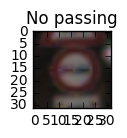

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train_file))
image = X_train_file[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
label_name = labels[y_train_file[index]][1]
plt.title(label_name.decode('UTF-8'))
print(y_train_file[index])


Number of labels :  43


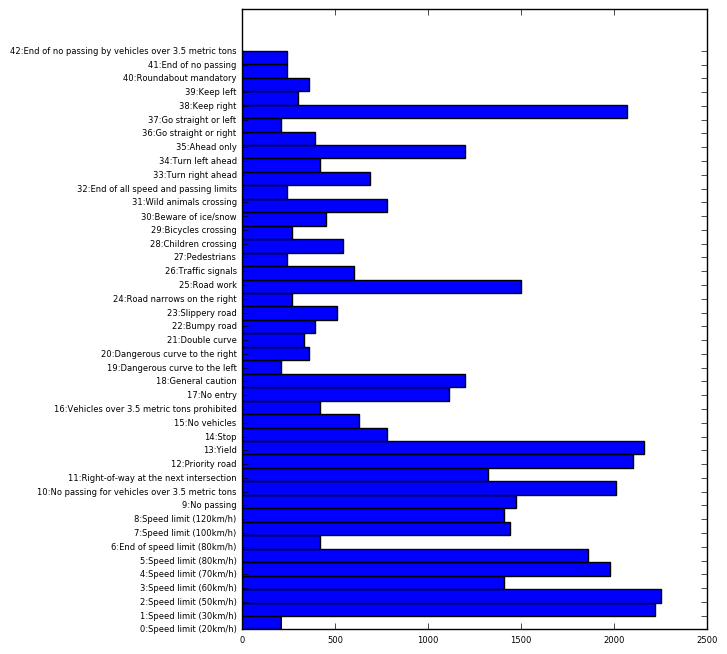

In [4]:
#What is the distribution of the data (per label)
print('Number of labels : ', len(labels))
hist_xticks = ['{}:{}'.format(t[0],t[1].decode('UTF-8')) for t in labels]
#print(hist_xticks)

fig = plt.figure(figsize=(6,8))

ax = plt.subplot() # Defines ax variable by creating an empty plot

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(6) # Size here overrides font_prop
    
plt.hist(y_train_file, bins=len(labels), orientation="horizontal")
plt.yticks( np.arange(len(labels)), hist_xticks,  rotation=0)
plt.show()

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_file, y_train_file, test_size=0.20, random_state=42)


from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

X_train = (X_train-128.)/255.

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [6]:
import tensorflow as tf

EPOCHS = 40
BATCH_SIZE = 512

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [7]:
# Calculate weights shape for a "VALID" padding convolution
import math
def conv_weight_shape(in_height=28, filter_height=3, strides=1):
    out_height = math.ceil(float(in_height - filter_height + 1) / float(strides))
    return out_height

# Let's try!
print(conv_weight_shape(in_height=14, filter_height=5, strides=1))


10


In [8]:
# Creating reusable function for creating weights and naming them in the network
def add_weights(weights_dict, name, shape, stddev=0.02):
    weights_dict[name] = tf.Variable(tf.random_normal(shape, stddev=stddev), name=name)
    return weights_dict

# Creating reusable function for creating weights and naming them in the network
def add_bias(bias_dict, name, shape, mean=0.1, stddev=0.05):
    bias_dict[name] = tf.Variable(tf.random_normal(shape, mean=mean, stddev=stddev), name=name)
    return bias_dict

In [9]:
# Creating reusable function for creating convolutional layer
# weights_dict is in the form {'weight_name1' : weights_values1, ...}
def conv2d(x, weights_dict,weights_name, bias_dict, bias_name, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, weights_dict[weights_name], strides=[1, strides, strides,  1], padding=padding)
    x = tf.nn.bias_add(x, bias_dict[bias_name])
    return x

In [27]:
sigma = math.sqrt(3./(32*32*1 + 28*28*6)/128)
print(sigma)

0.002022805556259858


In [28]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):    
    # Hyperparameters
    mu = 0
    sigma = math.sqrt(3./(32*32*1 + 28*28*6))
    alpha = 1e-4
    
    weights = dict()
    biases = dict()
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    in_channels =  x.get_shape()[-1].value
    shape = [filter_height, filter_width, in_channels, out_channels] = [5, 5, in_channels, 6]
    weights =  add_weights(weights, 'w1_conv', shape, stddev=sigma )
    biases =  add_bias(biases, 'b1_conv', [shape[-1]])
    conv_layer1 = conv2d(x, weights,'w1_conv', biases, 'b1_conv')
    
    # TODO: Activation.
    # layer1 = tf.nn.relu(conv_layer1)
    layer1 = tf.maximum(alpha*conv_layer1,conv_layer1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_strides = pool_filter_shape = [1, 2, 2, 1]
    padding = 'VALID'
    pooling_layer1 = tf.nn.max_pool(layer1, pool_filter_shape, pool_strides, padding)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    in_channels =  pooling_layer1.get_shape()[-1].value
    shape = [filter_height, filter_width, in_channels, out_channels] = [5, 5, in_channels, 16]
    weights =  add_weights(weights, 'w2_conv', shape)
    biases =  add_bias(biases, 'b2_conv', [shape[-1]])
    conv_layer2 = conv2d(pooling_layer1, weights,'w2_conv', biases, 'b2_conv')
    
    # TODO: Activation.
    # layer2 = tf.nn.relu(conv_layer2)
    layer2 = tf.maximum(alpha*conv_layer2,conv_layer2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pooling_layer2 = tf.nn.max_pool(layer2, pool_filter_shape, pool_strides, padding)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat_layer2 = tf.contrib.layers.flatten(pooling_layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    in_channels =  flat_layer2.get_shape()[-1].value
    shape = [in_channels, 120]
    weights = add_weights(weights,  'w3_full', shape)
    bias = add_bias(weights,  'b3_full', [shape[-1]])
    full_layer3 = tf.matmul(flat_layer2, weights['w3_full']) + bias['b3_full']

    # TODO: Activation.
    # layer3 = tf.nn.relu(full_layer3)
    layer3 = tf.maximum(alpha*full_layer3,full_layer3)
    layer3 = tf.nn.dropout(layer3, dropout)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    in_channels =  layer3.get_shape()[-1].value
    shape = [in_channels, 84]
    weights = add_weights(weights,  'w4_full', shape)
    bias = add_bias(weights,  'b4_full', [shape[-1]])
    full_layer4 = tf.matmul(layer3, weights['w4_full']) + bias['b4_full']

    # TODO: Activation.
    #layer4 = tf.nn.relu(full_layer4)
    layer4 = tf.maximum(alpha*full_layer4,full_layer4)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    in_channels =  layer4.get_shape()[-1].value
    shape = [in_channels, 43]
    weights = add_weights(weights,  'w5_full', shape)
    bias = add_bias(weights,  'b5_full', [shape[-1]])
    full_layer5 = tf.matmul(layer4, weights['w5_full']) + bias['b5_full']
    
    logits = full_layer5
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [29]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [30]:
rate = 0.002

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [31]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [32]:
dropout = 0.5  # Dropout, probability to keep units

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,  keep_prob: dropout})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.047

EPOCH 2 ...
Validation Accuracy = 0.097

EPOCH 3 ...
Validation Accuracy = 0.284

EPOCH 4 ...
Validation Accuracy = 0.315

EPOCH 5 ...
Validation Accuracy = 0.342

EPOCH 6 ...
Validation Accuracy = 0.370

EPOCH 7 ...
Validation Accuracy = 0.403

EPOCH 8 ...
Validation Accuracy = 0.493

EPOCH 9 ...
Validation Accuracy = 0.531

EPOCH 10 ...
Validation Accuracy = 0.583

EPOCH 11 ...
Validation Accuracy = 0.636

EPOCH 12 ...
Validation Accuracy = 0.650

EPOCH 13 ...
Validation Accuracy = 0.676

EPOCH 14 ...
Validation Accuracy = 0.702

EPOCH 15 ...
Validation Accuracy = 0.725

EPOCH 16 ...
Validation Accuracy = 0.731

EPOCH 17 ...
Validation Accuracy = 0.751

EPOCH 18 ...
Validation Accuracy = 0.758

EPOCH 19 ...
Validation Accuracy = 0.770

EPOCH 20 ...
Validation Accuracy = 0.781

EPOCH 21 ...
Validation Accuracy = 0.808

EPOCH 22 ...
Validation Accuracy = 0.792

EPOCH 23 ...
Validation Accuracy = 0.814

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [33]:
# Evaluate the model

with tf.Session() as sess:
    dropout = 1
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_file, y_test_file)
    print("Test Accuracy = {:.1f}% on {} examples".format(test_accuracy*100,len(y_test_file)))




Test Accuracy = 81.6% on 12630 examples


Trying with a random image
Label for this image (13, b'Yield')
Neural Network found (13, b'Yield')


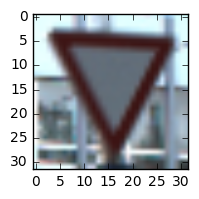

In [35]:
print('Trying with a random image')
index = random.randint(0, len(X_test_file))
image = X_test_file[index].squeeze()
plt.figure(figsize=(2,2))
print('Label for this image', labels[y_test_file[index]])
with tf.Session() as sess:
    dropout = 1
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    result = sess.run(logits, feed_dict={x: image.reshape(1, 32,32,3) ,  keep_prob: dropout} )
    print('Neural Network found',  labels[np.argmax(result)])
plt.imshow(image)

plt.show()

Todo : 
- Checkout this page to evaluate the performance of the Neural Network
http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html
and
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

- Keep track of progress when trying out different architecture
- Try Batch Normalization
- Use Data augmentation to even-out distribution of the training data 
- Try Shallow Residual Neural Network ideas
